In [1]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split


In [13]:
csv_file = 'archive/images.csv'
base_directory = 'archive/images_original'
dest_dir = 'archive/new_dataset'

data = pd.read_csv(csv_file)

train_dir = 'archive/train_dataset'
val_dir = 'archive/val_dataset'
test_dir = 'archive/test_dataset'

# Split data into training (70%), validation (15%), and test (15%) sets
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Move all images to the correct directories
def move_images(data, dest_dir):
    for index, row in data.iterrows():
        image_path = row['image'] + ".jpg"
        class_name = ''
        if index < 10:
            print(row['label'])
        if row['label'] == 'Blazer' or row['label'] =='Longsleeve':
            class_name = 'Longsleeve'
        elif row['label'] == 'Polo' or row['label'] =='T-Shirt':
            class_name = 'T-Shirt'
        elif row['label'] == 'Blouse' or row['label'] =='Body' or row['label'] =='Dress' or row['label'] =='Other' or row['label'] == 'Top' or row['label'] =='Undershirt':
            class_name = 'Other'
        elif row['label'] == 'Skirt' or row['label'] == 'Shirt':
            class_name = 'Shorts'
        else:
            class_name = row['label']
         
        src_path = os.path.join(base_directory, image_path)
        dest_path = os.path.join(dest_dir, class_name)
        os.makedirs(dest_path, exist_ok=True)
        if os.path.exists(src_path):
            shutil.copy(src_path, dest_path)
            
move_images(train_data, train_dir)
move_images(val_data, val_dir)
move_images(test_data, test_dir)


Shirt
Not sure
T-Shirt
T-Shirt
Not sure
T-Shirt
Shorts
Shoes
Shoes
Pants


In [14]:
import shutil
import os

def delete_dir(folder_path):
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
delete_dir('archive/train_dataset/Skip')
delete_dir('archive/train_dataset/Hat')
delete_dir('archive/train_dataset/Not sure')
delete_dir('archive/train_dataset/Shoes')
delete_dir('archive/val_dataset/Skip')
delete_dir('archive/test_dataset/Skip')
delete_dir('archive/val_dataset/Not sure')
delete_dir('archive/test_dataset/Not sure')
delete_dir('archive/val_dataset/Hat')
delete_dir('archive/test_dataset/Hat')
delete_dir('archive/val_dataset/Shoes')
delete_dir('archive/test_dataset/Shoes')
delete_dir('archive/test_dataset/Outwear')
delete_dir('archive/val_dataset/Outwear')
delete_dir('archive/test_dataset/Outwear')


In [15]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization

/Users/soumilgirdhar/tidy_vision/venv2/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [19]:
train_dir = 'archive/train_dataset'
val_dir = 'archive/val_dataset'

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')




Found 3176 images belonging to 7 classes.
Found 1527 images belonging to 15 classes.


In [20]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size
)

Epoch 1/20


/Users/soumilgirdhar/tidy_vision/venv2/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 6/99 ━━━━━━━━━━━━━━━━━━━━ 5:18 3s/step - accuracy: 0.1556 - loss: 2.2980

KeyboardInterrupt: 

In [10]:
model.save('classifier_model_20EPOCH_VGG16.h5')

In [28]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  
)
predictions = model.predict(test_generator)


Found 694 images belonging to 16 classes.


/Users/soumilgirdhar/tidy_vision/venv2/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step


In [12]:
import numpy as np
y_pred = np.argmax(predicciones, axis=1)

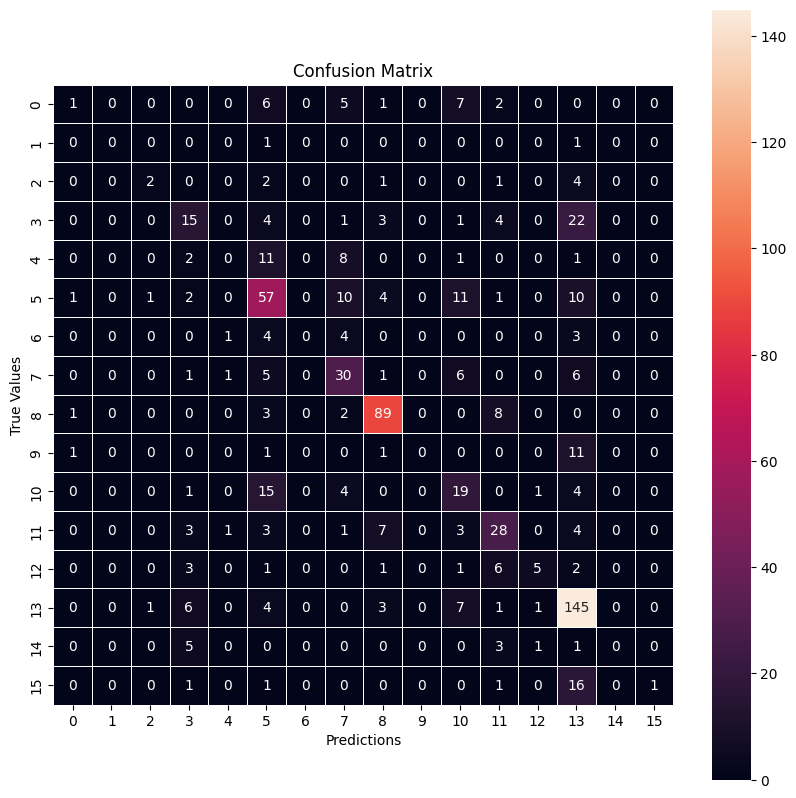

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


y_true = test_generator.classes

confusion_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt="d", linewidths=.5, square=True)
plt.xlabel('Predictions')
plt.ylabel('True Values')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.jpg')
plt.show()


In [30]:
from tensorflow.keras.preprocessing import image
import numpy as np


image_path = 'tshirt/1984.jpg'  

img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0 


In [32]:

predictions = model.predict(img_array)


class_labels = list(train_generator.class_indices.keys()) 
predicted_class = class_labels[np.argmax(predictions)]

print("Clase predicha:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
Clase predicha: T-Shirt
